In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lib.lattice import Lattice2D


In [90]:
def make_random_colored_lat(dimX, dimY) -> Lattice2D:
    lat = Lattice2D(dimX, dimY)
    num_colors = len(lat.colors)
    new_colors = np.random.choice([-1, 1], num_colors)
    lat.color_lattice(new_colors)
    return lat

In [91]:
lat = make_random_colored_lat(3, 3)
print(lat)

000---001---002
 |  #  |  #  |
003---004---005
 |  #  |  #  |
006---007---008



In [92]:
Sx, Sz = lat.getSx(), lat.getSz()
parityX = lat.pcheckX()
parityZ = lat.pcheckZ()
print(Sx, Sz)

['XXXXXX___', '___XXXXXX'] ['ZZ_______', '_ZZ______', '___ZZ____', '______ZZ_', '____ZZ___', '_______ZZ']


# Typical Error Sequences

## Count number of typical error sequences

In [93]:
def generate_all_pauli_strings(n):
    """
    generate all possible n-qubit Pauli strings
    """
    if n == 1:
        return ['_', 'X', 'Y', 'Z']
    else:
        return [p + q for p in generate_all_pauli_strings(1) for q in generate_all_pauli_strings(n-1)]
    
def index_to_pauli_string(idx, n):
    """
    convert an index to a Pauli string by converting the index to quaternary
    """
    return np.base_repr(idx, base=4).zfill(n).replace('0', '_').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')

In [94]:
index_to_pauli_string(1, 4)

'___X'

In [95]:
def error_distribution_func_1q(pauli_string, rates):
    px = rates[0]
    py = rates[1]
    pz = rates[2]
    probs = {'_': 1-px-py-pz, 'X': px, 'Y': py, 'Z': pz}
    # prob is the joint probability of the error string
    prob = 1
    for p in pauli_string:
        prob *= probs[p]
    return prob

In [96]:
def calculate_error_distribution(n, rates):
    """
    calculate the error distribution for n-qubit Pauli strings
    """
    all_pauli_strings = generate_all_pauli_strings(n)
    error_distribution = np.zeros(4**n)
    for idx, pauli_string in enumerate(all_pauli_strings):
        error_distribution[idx] = error_distribution_func_1q(pauli_string, rates)
    return error_distribution


def entropy_from_distribution(distribution):
    """
    calculate the entropy from a distribution
    """
    return -np.sum(distribution * np.log2(distribution + 1e-10))

In [135]:
dist = calculate_error_distribution(10, [0.01, 0.01, 0.01])
len(dist)

1048576

In [136]:
entropy_from_distribution(dist)

2.4193975419146536

In [137]:
print(4**10, 2**4)

1048576 16


## 

# Maximum likelihood decoder

In [100]:
from lib.color_compass import pauli2vector, twisted_prod_mat, twisted_product

def pauli_to_error_class(pauli, logicals, Sx, Sz):
    """
    convert a Pauli string to an error class representative
    """
    pauli_vec = pauli2vector(pauli)
    lX_vec, lZ_vec = [pauli2vector(logicals[0]), pauli2vector(logicals[1])]
    sX_vec = [pauli2vector(s) for s in Sx]
    sZ_vec = [pauli2vector(s) for s in Sz]

    logical_checks = [twisted_product(pauli_vec, lX_vec), twisted_product(pauli_vec, lZ_vec)]
    Sx_checks = [twisted_product(pauli_vec, s) for s in sX_vec]
    Sz_checks = [twisted_product(pauli_vec, s) for s in sZ_vec]
    return logical_checks, Sx_checks, Sz_checks

def error_partition_from_lattice(pauli, lat):
    """
    given a Pauli string and a lattice, return the error partition
    """
    logical_checks, Sx_checks, Sz_checks = pauli_to_error_class(pauli, [lat.Lx, lat.Lz], lat.getSx(), lat.getSz())
    return logical_checks, Sx_checks, Sz_checks

In [101]:
from tqdm import tqdm
def binary_tuple_to_decimal_idx(t):
    return sum([2**i for i in range(len(t)) if t[i] == 1])

def make_joint_distribution(lat, rates):
    """
    Calculates P(L, \Gamma) and P(L | \Gamma = \gamma) for a given lattice and error rates
    """
    Sx = lat.getSx()
    Sz = lat.getSz()
    joint_distribution = np.zeros((4, 2**len(Sx), 2**len(Sz)))
    pauli_index_range = range(4**lat.size())
    for pauli_idx in tqdm(pauli_index_range):
        pauli = index_to_pauli_string(pauli_idx, lat.size())
        logical_checks, Sx_checks, Sz_checks = error_partition_from_lattice(pauli, lat)
        prob = error_distribution_func_1q(pauli, rates)


        syndrome_Sx = tuple(Sx_checks)
        syndrome_Sz = tuple(Sz_checks)
        syndrome_logical = tuple(logical_checks)

        Sx_idx = binary_tuple_to_decimal_idx(syndrome_Sx)
        Sz_idx = binary_tuple_to_decimal_idx(syndrome_Sz)
        logical_idx = binary_tuple_to_decimal_idx(syndrome_logical)

        joint_distribution[logical_idx, Sx_idx, Sz_idx] += prob

    
    return joint_distribution

In [103]:
joint_dist = make_joint_distribution(lat, [0.01, 0.02, 0.03])

100%|██████████| 262144/262144 [00:19<00:00, 13584.34it/s]


In [104]:
joint_dist.shape

(4, 4, 64)

In [105]:
def calculate_logical_marginal(joint_distribution):
    """
    Calculates P(L) for a given joint distribution P(L, Sx, Sz)
    """
    return np.sum(joint_distribution, axis=(1,2))
   
def calculate_syndrome_marginal(joint_distribution):
    """
    Calculates P(Sx, Sz) for a given joint distribution P(L, Sx, Sz)
    """
    return np.sum(joint_distribution, axis=0)

def calculate_syndrome_prob_given_logical(joint_distribution):
    """
    Calculates P(Sx, Sz | L) for a given joint distribution P(L, Sx, Sz)
    """
    return joint_distribution/np.sum(joint_distribution, axis=0)

def calculate_logical_prob_given_syndrome(joint_distribution, sx_idx, sz_idx):
    """
    Calculates P(L | Sx, Sz) for a given joint distribution P(L, Sx, Sz)
    """
    return joint_distribution[:, sx_idx, sz_idx]/np.sum(joint_distribution[:, sx_idx, sz_idx])

    

In [140]:
def construct_maxlike_decoder_lookup(joint_distribution):
    """
    Construct a lookup table for the maximum likelihood decoder

    The lookup table is a dictionary with keys (Sx, Sz) and values L

    The value L is the most likely logical error given the syndrome (Sx, Sz)

    First, calculate P(Sx, Sz | L) for all L and each Sx, Sz
    Then, for each Sx, Sz, find the L that maximizes P(L | Sx, Sz)
    """
    maxlike_decoder_lookup = {}
    for sx_idx in range(joint_distribution.shape[1]):
        for sz_idx in range(joint_distribution.shape[2]):
            prob_given_syndrome = calculate_logical_prob_given_syndrome(joint_distribution, sx_idx, sz_idx)
            max_idx = np.argmax(prob_given_syndrome)
            maxlike_decoder_lookup[(sx_idx, sz_idx)] = max_idx
    return maxlike_decoder_lookup


def calculate_ml_decoder_failure_prob(joint_distribution, maxlike_decoder_lookup=None):
    """
    calculate the ML error class decoder failure probability from the joint distribution

    Given P(L, Y), calculate the probability of failure of the ML decoder

    Calculate 
    \sum_{y} Pr(Y=y) Pr(L \neq L_{ML} | Y=y)

    """
    if maxlike_decoder_lookup is None:
        maxlike_decoder_lookup = construct_maxlike_decoder_lookup(joint_distribution)
    prob_failure = 0
    for sx_idx in range(joint_distribution.shape[1]):
        for sz_idx in range(joint_distribution.shape[2]):
            maxlike_class = maxlike_decoder_lookup[(sx_idx, sz_idx)]
            for logical_idx in range(joint_distribution.shape[0]):
                if logical_idx != maxlike_class:
                    prob_failure += joint_distribution[logical_idx, sx_idx, sz_idx]
    return prob_failure
    
    


In [114]:
ml_decoder_table = construct_maxlike_decoder_lookup(joint_dist)
fail_prob = calculate_ml_decoder_failure_prob(joint_dist, ml_decoder_table)
fail_prob

0.039609287007966704

In [130]:
rate_range = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
fail_probs = []
for rate in rate_range:
    joint_dist = make_joint_distribution(lat, [rate, rate, rate])
    ml_decoder_table = construct_maxlike_decoder_lookup(joint_dist)
    fail_prob = calculate_ml_decoder_failure_prob(joint_dist, ml_decoder_table)
    fail_probs.append(fail_prob)

100%|██████████| 262144/262144 [00:19<00:00, 13208.70it/s]


(0.0, 0.06)

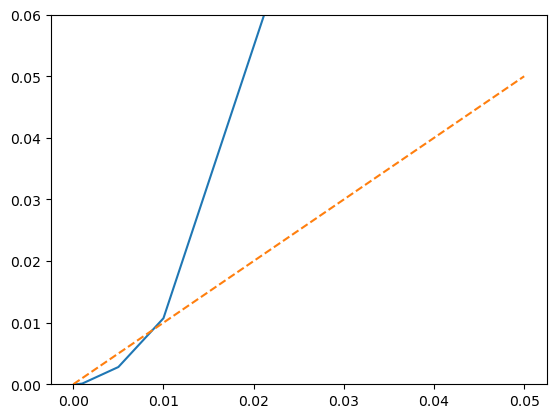

In [134]:
plt.plot(rate_range, fail_probs)
plt.plot((0, 0.05), (0, 0.05), '--')
plt.ylim(0, 0.06)

In [177]:
rates = [0.01, 0.02, 0.03]
joint_dist = make_joint_distribution(lat, rates)

 30%|██▉       | 78435/262144 [00:05<00:14, 12886.98it/s]

In [179]:
def calculate_conditional_entropy_logical_on_stabilizer(joint_distribution):
    """
    Calculates H(L | Sx, Sz) for a given joint distribution P(L, Sx, Sz)
    """
    conditional_entropy = 0
    for l_idx in range(joint_distribution.shape[0]):
        for sx_idx in range(joint_distribution.shape[1]):
            for sz_idx in range(joint_distribution.shape[2]):
                p_stab = np.sum(joint_distribution[:, sx_idx, sz_idx])
                p_joint = joint_distribution[l_idx, sx_idx, sz_idx]
                conditional_entropy += p_joint*np.log2(p_joint/p_stab)
    return -conditional_entropy

def calculate_logical_entropy(joint_distribution):
    """
    Calculates H(L) for a given joint distribution P(L, Sx, Sz)
    """
    l_marginal = calculate_logical_marginal(joint_distribution)
    return -np.sum([p*np.log2(p) for p in l_marginal if p > 0])

def calculate_syndrome_entropy(joint_distribution): 
    """
    Calculates H(Sx, Sz) for a given joint distribution P(L, Sx, Sz)
    """
    s_marginal = calculate_syndrome_marginal(joint_distribution)
    return -np.sum(s_marginal*np.log2(s_marginal), axis=(0, 1))

def calculate_joint_entropy(joint_distribution):
    """
    Calculates H(L, Sx, Sz) for a given joint distribution P(L, Sx, Sz)
    """
    return -np.sum(joint_distribution*np.log2(joint_distribution), axis=(0,1,2))

In [180]:
p_fail = calculate_ml_decoder_failure_prob(joint_dist)

In [184]:
h_cond = calculate_conditional_entropy_logical_on_stabilizer(joint_dist)
h_logical = calculate_logical_entropy(joint_dist)
h_syn = calculate_syndrome_entropy(joint_dist)
h_joint = calculate_joint_entropy(joint_dist)
print('Conditional entropy:', h_cond)
print('Logical entropy:', h_logical)
print('Syndrome entropy:', h_syn)
print('Joint entropy:', h_joint)
print('Mutual information:', h_logical + h_syn - h_joint)   

Conditional entropy: 0.18760071364365044
Logical entropy: 0.979572583887983
Syndrome entropy: 2.975090092033515
Joint entropy: 3.1626908056771637
Mutual information: 0.7919718702443341


In [186]:
h_syn - h_cond

2.787489378389864

In [185]:
print(f"Failure probability: {p_fail}")

def binary_entropy(p):
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

print(f"Failure binary entropy: {binary_entropy(p_fail)}")

Failure probability: 0.039609287007966704
Failure binary entropy: 0.24049790800441861


In [162]:
print(f"Succeed probability: {1-p_fail}")

Succeed probability: 0.9603907129920333


In [163]:
-np.log2(1-p_fail)

0.05830664215734947

In [164]:
print(h_logical)

0.979572583887983


In [165]:
2**-h_cond

0.8780647808907209

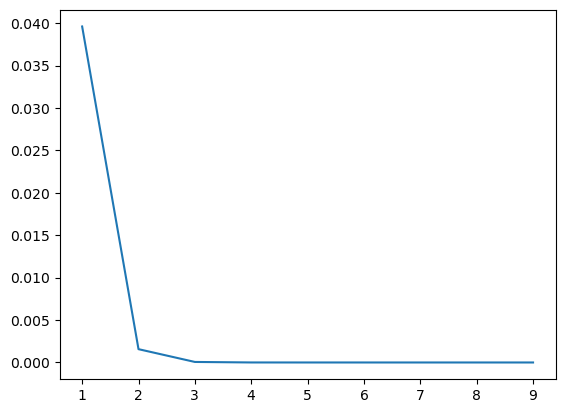

In [149]:
rs = range(1, 10)
p_powers = [